# Video Outline

30 seconds of video - what do we show?


1) Einstein from noise explains MRA - applications in signal processing
    * MRA - Multi Reference alignment
    * Start with one reference -> zoom out to show multiple.
    * Align them visually to a reference.
    
2) 

In [5]:
from code_2d import add_noise, align, fft_2d, ifft_2d
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from jax import random

#######################
import matplotlib
matplotlib.use('ps')
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}\usepackage{xcolor}')
#########################

def load_image(s=4):
    pic = mpimg.imread('/home/emastr/github/multireference-alignment/figures/einstein_tongue_2.jpg')[:, :, 0]
    # Cut out a square centered on the face
    pic = pic[130:481, 300:651]
    pic = pic[:-1:s, :-1:s]
    (L1, L2) = pic.shape
    t1 = jnp.linspace(0, 1, L1, endpoint=False)
    t2 = jnp.linspace(0, 1, L2, endpoint=False)
    T1, T2 = jnp.meshgrid(t1, t2)
    vingette = 1/(1 + jnp.exp(-40 * (0.4**2 - ((T1 - 0.5) ** 2 + (T2 - 0.52) ** 2))))
    pic = pic * vingette.T
    pic = pic / jnp.linalg.norm(pic)
    return jnp.array(pic)

def get_moments(y_list, std):
    yfft_list = [jnp.abs(fft_2d(y))**2 for y in y_list]
    y_moments = jnp.mean(jnp.array(yfft_list), axis=0) - std**2*(y_list[0].shape[0]*y_list[0].shape[1])
    return jnp.sqrt(jnp.abs(y_moments))#jnp.sqrt(jnp.maximum(y_moments, 0.)).real

def project_moments(x, mom):
    xfft = fft_2d(x)
    xupdate = xfft * mom / jnp.abs(xfft)
    xfft = xfft.at[1:,1:].set(xupdate[1:,1:])
    return ifft_2d(xfft).real

def get_moments_M(M, x, std):
    y_list = []
    key = random.PRNGKey(0)
    for i in range(M):
        key0, key = random.split(key)
        y,_,_,_ = add_noise(key, x, std)
        y_list.append(y)
    return get_moments(y_list, std)
    


sigma = 0.02
x = load_image(s=2)
x = x - jnp.mean(x)
NUM = 20*12
y_list = []
key = random.PRNGKey(0)
for i in range(NUM):
    key0, key = random.split(key)
    y,_,_,_ = add_noise(key, x, sigma)
    y_list.append(y)
    
def roll_img(img, s1, s2):
    return jnp.roll(y, (int(s1), int(s2)), axis=(0, 1))

# Template
tmpl = jnp.zeros_like(x)
X, Y = jnp.meshgrid(jnp.linspace(0, 1, tmpl.shape[0]), jnp.linspace(0, 1, tmpl.shape[1]))
tmpl = (Y < 0.8)*(jnp.abs(X-0.6)*2 < 0.3+Y-0.35)  #tmpl = ((((X-0.5)**2 + (Y-0.5)**2) < 1.3**2) * (jnp.abs(X-0.5)*jnp.abs(Y-0.5)))>0.001
tmpl_mask = jnp.where(tmpl > 0.5, 1, jnp.nan)
y_al = jnp.zeros_like(x)
#mom = jnp.abs(fft_2d(x))

mom = get_moments(y_list, sigma)


In [6]:
key = random.PRNGKey(0)
n, m = 20, 12

scenes = [1,2,3,4,5]

scale = 1
img_list = []
fig = plt.figure(figsize=(n*scale, m*scale))
for i in range(n):
    img_list.append([])
    for j in range(m):
        img = plt.imshow(y_list[m*i+j], cmap='gray', extent=[i, (i+0.8), j, (j+0.8)])
        img_list[i].append(img)
plt.axis("off")
plt.axis("equal")
plt.tight_layout()
#title = plt.title(r'\textcolor{gray}{Multi}-\textcolor{black}{reference} \textcolor{gray}{Alignment}\qquad\qquad\qquad V. Shahverdi, E. Strom, J. Andén', fontsize=50, ha="center", va="center")
title = plt.title(r'Constrained Multireference Alignment - V. Shahverdi, E. Strom, J. Andén', fontsize=50, ha="center", va="center")
#plt.gca().set_facecolor('black')
#fig.patch.set_facecolor('black')


def zoomfunc(t, x0, x1):
    return x0 + (x1-x0)/(1+jnp.exp(-(t-0.6)/0.07))

def lerp(t, x0, x1):
    return x0 + t*(x1-x0)

def zoomfunc_box(t, xlim0, ylim0, xlim1, ylim1):
    xlim = [zoomfunc(t, xlim0[0], xlim1[0]), zoomfunc(t, xlim0[1], xlim1[1])]
    ylim = [zoomfunc(t, ylim0[0], ylim1[0]), zoomfunc(t, ylim0[1], ylim1[1])]
    return xlim, ylim


# Slowly zoom out from the first image
fps = 30

print("###############################################")
print("Scene 1: Zoom out from bottom left")
print("###############################################")
T = 4 # Seconds
nframes = fps*T
total_frames = 0
for frame in range(nframes):
    t_per_T = frame/nframes
    plt.xlim(-0.05, zoomfunc(t_per_T, 0.8, n)+0.05)
    plt.ylim(-0.05, zoomfunc(t_per_T, 0.8, m)+0.05)
    if 1 in scenes:
        fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')

#title.set_text(r'\textcolor{black}{Multi}-\textcolor{black}{reference} \textcolor{gray}{Alignment}\qquad\qquad\qquad V. Shahverdi, E. Strom, J. Andén')
print("###############################################")
print("Scene 2: Zoom in on bottom right")
print("###############################################")
T = 1.5
total_frames += nframes
nframes = int(fps*T)
for frame in range(nframes):
    t_per_T = frame/nframes
    xlim, ylim = zoomfunc_box(t_per_T, [0, n], [0, m], [n-1.0, n+1.0], [-0.1, 0.8])
    plt.xlim(-0.05+xlim[0], xlim[1]+0.05)
    plt.ylim(-0.05+ylim[0], ylim[1]+0.05)
    if 2 in scenes:
        fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')
    
print("###############################################")
print(" Scene 3: Add template, repeat for all data:")
print("###############################################")
#title.set_text(r'\textcolor{black}{Multi}-\textcolor{black}{reference} \textcolor{black}{Alignment}\qquad\qquad\qquad V. Shahverdi, E. Strom, J. Andén')

img0 = img_list[-1][0]
extent0 = img0.get_extent()
y = img0.get_array()
y_al = jnp.zeros_like(y)
img_tmpl = plt.imshow(tmpl_mask, cmap="RdBu", alpha=0.5, extent=extent0)
txt_tmpl = plt.text(0.5*(extent0[0]+extent0[1]), extent0[2]-0.1, r'Align to \textcolor{red}{Template}', fontsize=40, ha="center", va="center")
xlim0, ylim0 = [n-1.0, n+1.0], [-0.1, 0.8]
img2 = None

T = 3
nStart = 12
for i in range(nStart):  
    print(f"Step {i} of averaging", end="\r")
    conv = ifft_2d(fft_2d(tmpl) * jnp.conj(fft_2d(y))).real
    imax = jnp.argmax(conv)
    s1, s2 = jnp.unravel_index(imax, conv.shape)
    
    
    # Subscene 1: Align to template
    total_frames += nframes
    tfrac = 0.4
    nframes = int(fps*T*tfrac)
    
    for frame in range(nframes):
        t_per_T = frame/nframes
        s1t, s2t = zoomfunc(t_per_T, 0, s1), zoomfunc(t_per_T, 0, s2)
        img0.set_array(roll_img(y, s1t, s2t))
        if 3 in scenes:
            fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')
    
    # Add to aligned image
    a = 1/(i+1)
    y_al = y_al * (1 - a) + roll_img(y, s1, s2) * a
        
    
    # Subscene 2: Pan to the next image
    total_frames += nframes
    nframes = int(fps*T*(1-tfrac))
    
    xlim1, ylim1 = [xlim0[0]-1., xlim0[1]-1.], [ylim0[0], ylim0[1]]
    img1 = img_list[-(i+2)][0]
    extent1 = img1.get_extent()
    for frame in range(nframes):
        t_per_T = frame/nframes
        
        # Interpolate between positions 
        xlim, ylim = zoomfunc_box(t_per_T, xlim0, ylim0, xlim1, ylim1)
        exx, exy = zoomfunc_box(t_per_T, extent0[0:2], extent0[2:], extent1[0:2], extent1[2:])
        extent = [exx[0], exx[1], exy[0], exy[1]]
        
        # Move images along camera
        img_tmpl.set_extent(extent)
        txt_tmpl.set_position((0.5*(extent[0]+extent[1]), extent[2]-0.1))
        if img2 is not None:
            img2.set_extent([exx[0]+1, exx[1]+1, exy[0], exy[1]])
        
        plt.xlim(-0.05+xlim[0], xlim[1]+0.05)
        plt.ylim(-0.05+ylim[0], ylim[1]+0.05)
        if 3 in scenes:
            fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')
    
    #img1.set_array(img1.get_array() + img0.get_array().filled(0.))
    if img2 is not None:
        img2.set_array(y_al)
        img2.set_clim(vmin=jnp.min(y_al), vmax=jnp.max(y_al))
        #if i != nStart-1:
        img0.remove()
    else:
        img2 = img0

    img0 = img1
    extent0 = extent1
    xlim0, ylim0 = xlim1, ylim1
    y = img1.get_array()
    T = T*0.7 # Next half as long
    
print("###############################################")
print("Scene 4, Iterate fast")
print("###############################################")
total_frames += nframes
T = 3
nframes = fps*T
frames_per_image = 4
n_images = 300
n_skip = (n_images * frames_per_image) // nframes
#n_images = nframes//frames_per_image
img0 = plt.imshow(y, cmap='gray', extent=img_tmpl.get_extent(), zorder=-1)
print(f"Frames per image: {frames_per_image}")
for l in range(n_images):  
    key0, key = random.split(key)
    y,_,_,_ = add_noise(key, x, 0.02)
    img0.set_array(y)
    y = align(tmpl, y)
    a = 1/(nStart + l)
    y_al = y_al*(1-a) + project_moments(y, mom)*a
    #y_al = project_moments(y_al, mom)
    if l % n_skip == 0:
        img2.set_array(y_al)
        img2.set_clim(vmin=jnp.min(y_al), vmax=jnp.max(y_al))
        for frame in range(frames_per_image):
            print(f"Step {l} of averaging, frame {frame}", end="\r")
            if 4 in scenes:
                fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')
        total_frames += frames_per_image    
        
print("###############################################")
print("Scene 5, Switch to new template")
print("###############################################")
extent0 = img2.get_extent()
extent1 = img_tmpl.get_extent()
T = 4
for k in range(6):
    # Reset template
    tmpl = y_al
    y_al = jnp.zeros_like(y_al)
    
    
    img_tmpl.set_array(-jnp.where(tmpl>0.001, tmpl, jnp.nan))
    img_tmpl.set_clim(vmin=jnp.min(-tmpl), vmax=jnp.max(-tmpl))
    img_tmpl.set_extent(extent0)
    img_tmpl.set_alpha(0.)
    
    nframes = int(fps*T * 0.3)
    for frame in range(nframes):
        # Animate template moving over to the left
        t_per_T = frame/nframes
        exx, exy = zoomfunc_box(t_per_T, extent0[0:2], extent0[2:], extent1[0:2], extent1[2:])
        extent = [exx[0], exx[1], exy[0], exy[1]]
        alpha = float(zoomfunc(t_per_T, 0, 0.5))
        
        img2.set_extent(extent)
        img2.set_alpha(1.-2*alpha)
        img_tmpl.set_extent(extent)
        img_tmpl.set_alpha(alpha)
        if 5 in scenes:
            fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png",  bbox_inches='tight')

    if k ==0:
        txt_tmpl.set_text(r'Align to \textcolor{red}{new template}')
    if k==1:
        txt_tmpl.set_text("Repeat")
    total_frames += nframes
    
    nframes = int(fps*T * 0.7)
    frames_per_image = 4
    n_images = 300
    n_skip = (n_images * frames_per_image) // nframes
    
    img2.set_extent(extent0)
    img2.set_alpha(1.)
    # Animate optimization
    for l in range(n_images):  
        key0, key = random.split(key)
        y,_,_,_ = add_noise(key, x, 0.02)
        img0.set_array(y)
        y = align(tmpl, y)
        a = 1/(nStart + l)
        y_al = y_al*(1-a) + project_moments(y, mom)*a
        #y_al = project_moments(y_al, mom)
        if l % n_skip == 0:
            img2.set_array(y_al)
            img2.set_clim(vmin=jnp.min(y_al), vmax=jnp.max(y_al))
            for frame in range(frames_per_image):
                print(f"Step {l} of averaging, frame {frame}", end="\r")
                if 5 in scenes:
                    fig.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+total_frames:03d}.png", bbox_inches='tight')
            total_frames += frames_per_image  
    T = max(T*0.7,0.5) # Next half as long    

###############################################
Scene 1: Zoom out from bottom left
###############################################
###############################################
Scene 2: Zoom in on bottom right
###############################################
###############################################
 Scene 3: Add template, repeat for all data:
###############################################
###############################################
Scene 4, Iterate fast
###############################################
Frames per image: 4
###############################################
Scene 5, Switch to new template
###############################################


In [ ]:
from PIL import Image
import os

def convert_to_png(path):
    img = Image.open(path)
    img.save(path.replace('.ps', '.png'))

for path in os.listdir('/home/emastr/github/multireference-alignment/figures/anim/'):
    if path.endswith('.ps'):
        convert_to_png(f'/home/emastr/github/multireference-alignment/figures/anim/{path}')

In [9]:
import os

def save():
    os.system("ffmpeg -r 30 -i /home/emastr/github/multireference-alignment/figures/anim/2d_noisy_%03d.png -vcodec mpeg4 -b 20000k -y /home/emastr/github/multireference-alignment/figures/anim/movie.mp4")
    
save()

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

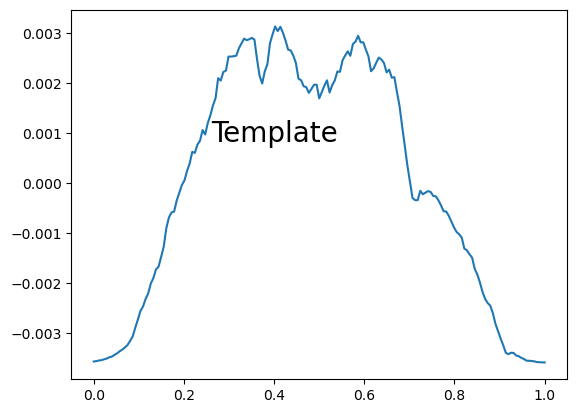

In [46]:
plt.plot(jnp.linspace(0, 1, x.shape[0]), jnp.mean(x, axis=1))   
txt = plt.text(0.4, 0, "Template", fontsize=20, ha="center", va="center")
txt.set_position((0.4, 0.001))

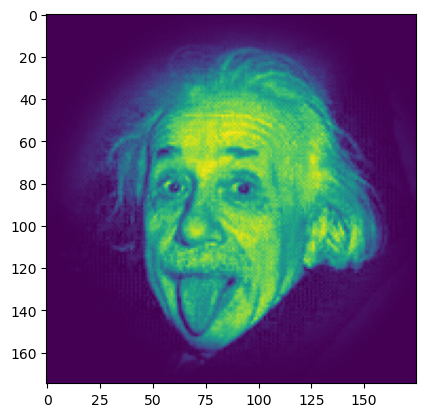

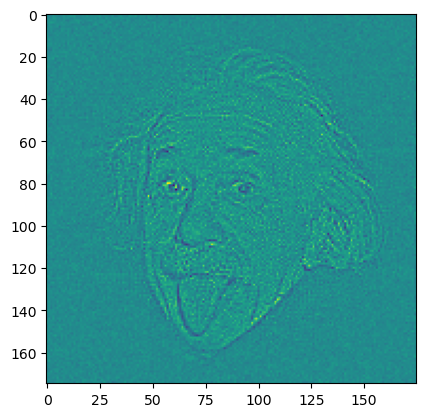

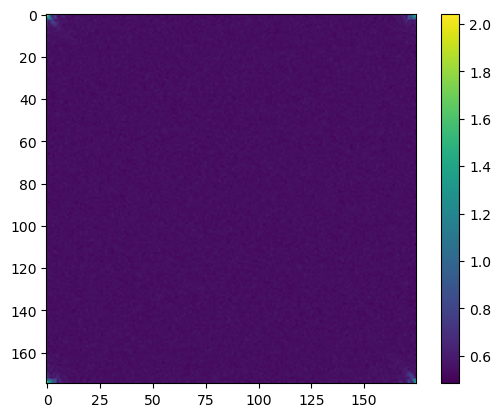

In [38]:
def project(x, mom):
    xfft = fft_2d(x)
    xproj = xfft * mom / jnp.abs(xfft)
    xfft = xfft.at[1:, 1:].set(xproj[1:, 1:])
    
    return ifft_2d(xfft).real


mom = get_moments(y_list, 0.02).real
plt.imshow(x)

plt.figure()
plt.imshow(project(x, mom))

plt.figure()
plt.imshow(jnp.log10(mom)) 
plt.colorbar()

In [236]:
img_list[-1][0].get_extent()

[19, 19.8, 0, 0.8]

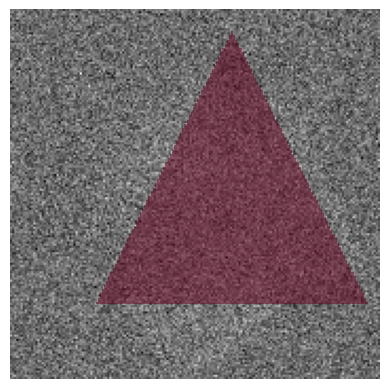

In [238]:
# Scene 3: Add template
def roll_img(img, s1, s2):
    return jnp.roll(y, (int(s1), int(s2)), axis=(0, 1))

# Template
tmpl = jnp.zeros_like(x)
X, Y = jnp.meshgrid(jnp.linspace(0, 1, tmpl.shape[0]), jnp.linspace(0, 1, tmpl.shape[1]))
tmpl = (Y < 0.8)*(jnp.abs(X-0.6)*2 < 0.3+Y-0.35)  #tmpl = ((((X-0.5)**2 + (Y-0.5)**2) < 1.3**2) * (jnp.abs(X-0.5)*jnp.abs(Y-0.5)))>0.001
tmpl_mask = jnp.where(tmpl > 0.5, 1, jnp.nan)
y_al = jnp.zeros_like(x)


# Get aligned shifts
y = y_list[0]
conv = ifft_2d(fft_2d(tmpl) * jnp.conj(fft_2d(y))).real
imax = jnp.argmax(conv)
s1, s2 = jnp.unravel_index(imax, conv.shape)

    
NUM = 20*12
img = plt.imshow(y_list[0], cmap='gray')
plt.imshow(tmpl_mask, cmap="RdBu", alpha=0.5)
plt.axis("off")

for frame in range(nframes):
    t_per_T = frame/nframes
    s1t, s2t = zoomfunc(t_per_T, 0, s1), zoomfunc(t_per_T, 0, s2)
    img.set_array(roll_img(y, s1t, s2t))
    plt.savefig(f"/home/emastr/github/multireference-alignment/figures/anim/2d_noisy_{frame+2*nframes:03d}.png")
     


#for k in range(0):
#    for i in range(NUM):
#        key0, key = random.split(key)
#        y,_,_,_ = add_noise(key, x, 0.02)
#        # Align y to tmpl:
#        y_al = y_al + align(tmpl, y)
#        
#    plt.figure()
#    plt.subplot(1,2,1)
#    plt.imshow(y_al, cmap='gray', extent=[i, (i+0.8), j, (j+0.8)])
#   plt.subplot(1,2,2)
#   plt.imshow(tmpl, cmap='gray', extent=[i, (i+0.8), j, (j+0.8)])
#    tmpl = y_al / jnp.linalg.norm(y_al)






ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:

#y = jnp.roll(x, (3, 3), axis=(0, 1))
#y, s1, s2 = align(x, y)
#print(s1, s2)

#L = 5

sigma = 1000
#x = jnp.sin(-2*jnp.pi*jnp.sin(2 * jnp.pi * T1) * jnp.sin(2 * jnp.pi * T2))
#x = jnp.zeros((L, L))
#x = x.at[0,0].set(1.)
#x = jnp.where(T1 > 0.5, 1, 0) * jnp.where(T2 > 0.5, 1, 0)


N = 1000
x = jnp.array(pic)

(L1, L2) = pic.shape
t1 = jnp.linspace(0, 1, L1+1)[:-1]
t2 = jnp.linspace(0, 1, L2+1)[:-1]
T1, T2 = jnp.meshgrid(t1, t2)

y = random.normal(subkey, (N, L1, L2))
y = align_average(x, y)
xfft = fft_2d(x)

alignment = []
N_list = [8, 16, 32, 64, 128, 256, 512]#, 2048]#, 2*2048, 4*2048]
for N in N_list:
    key, subkey = jax.random.split(key)
    y = random.normal(subkey, (N, L1, L2))
    y = align_average(x, y)
    yfft = fft_2d(y)
    cosine = jnp.mean(jnp.abs(((xfft * jnp.conj(yfft)).real )/ (jnp.abs(xfft) * jnp.abs(yfft))), axis=(0, 1))
    alignment.append(cosine)

# Split into subtasks
N = 512
Nbatch = 512
for i in range(7):
    for j in range(2**i):
        key, subkey = jax.random.split(key)
        noise = random.normal(subkey, (Nbatch, L1, L2))
        y = (y * N +  align_average(x, noise) * Nbatch) / (N + Nbatch)
        N = N + Nbatch
    yfft = fft_2d(y)
    cosine = jnp.mean(jnp.abs(((xfft * jnp.conj(yfft)).real )/ (jnp.abs(xfft) * jnp.abs(yfft))), axis=(0, 1))
    alignment.append(cosine)
    N_list.append(N)
    
